# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
# tf.enable_eager_execution() # this is commented out, when using tf1.
tfds = tf.data.Dataset
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [2]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import contextlib
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Load

In [0]:
IMAGE_SIZE = 28

In [0]:
mnist = tfk.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
x_test = (x_test.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

In [0]:
def plot_images(imgs, labs, n=4):
  for i,item in enumerate(zip(imgs,labs)):
    if i >= n**2: return
    img,lab = item[0],item[1]
    plt.subplot(n, n, i+1)
    plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(lab)), color="k")
    plt.subplots_adjust(hspace=0.4)
  plt.show()

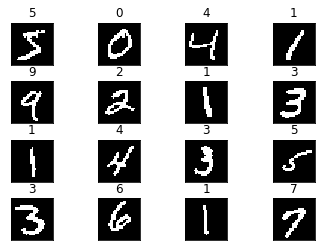

In [6]:
plot_images(x_train, t_train)

## Pipeline

In [0]:
TRAIN_BATCH_SIZE = 500
TRAIN_SAMPLE_SIZE = TRAIN_BATCH_SIZE*10
TEST_BATCH_SIZE = 1000

mnist_train = tfds.from_tensor_slices((x_train, t_train)).cache()
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)
mnist_train = mnist_train.shuffle(TRAIN_SAMPLE_SIZE, seed=0, reshuffle_each_iteration=True)
mnist_train = mnist_train.batch(TRAIN_BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.from_tensor_slices((x_test, t_test)).cache()
mnist_test = mnist_test.batch(TEST_BATCH_SIZE, drop_remainder=True)

# Model

## Encoder

In [0]:
class Encoder(tfk.Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.l1 = tfkl.Dense(512, activation='relu')
    self.l2 = tfkl.Dense(256, activation='relu')
    self.mu = tfkl.Dense(latent_dim, activation=None)
    self.logvar = tfkl.Dense(latent_dim, activation=None)
  
  def call(self, x):
    x = self.l1(x)
    x = self.l2(x)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return mu, logvar

## Decoder


In [0]:
class Decoder(tfk.Model):
  def __init__(self, output_dim):
    super(Decoder, self).__init__()
    self.l1 = tfkl.Dense(256, activation='relu')
    self.l2 = tfkl.Dense(512, activation='relu')
    self.l3 = tfkl.Dense(output_dim, activation=None)
    self.ls = [self.l1, self.l2, self.l3]

  def call(self, x):
    for layer in self.ls: x = layer(x)
    return x

## VAE

In [0]:
class VAE(tfk.Model):
  def __init__(self, input_dim, latent_dim):
    super(VAE, self).__init__()
    self._encoder = Encoder(latent_dim)
    self._decoder = Decoder(input_dim) # input_dim == output_dim
  
  def encode(self, x):
    return self._encoder(x)
  
  @tf.function
  def reparameterize(self, mu, logvar):
    eps = tf.random.normal(shape=mu.shape)
    return eps * tf.exp(logvar * .5) + mu
  
  def encode_and_reparametrize(self, x):
    mu, logvar = self.encode(x)
    return self.reparameterize(mu, logvar)
  
  def decode(self, z, to_prob=False):
    if to_prob:
      return tf.nn.sigmoid(self._decoder(z))
    else:
      return self._decoder(z)

# Training

## Util

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Loss

In [0]:
LOG2PI = tf.math.log(2.*np.pi)

def log_normal_pdf(samples, mu, logvar):
  return tf.reduce_sum( -.5 * ((samples-mu)**2. * tf.exp(-logvar) + logvar + LOG2PI), axis=-1)

def calc_loss(vae, x):
  mu, logvar = vae.encode(x)
  z = vae.reparameterize(mu, logvar)
  x_logit = vae.decode(z, to_prob=False)

  # reconstruction error
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=-1)

  # KL divergence
  logpz = log_normal_pdf(z, 0., 0.) # prior
  logqz_x = log_normal_pdf(z, mu, logvar) # approx posterior
  kl_div = logqz_x - logpz

  # negative ELBO
  return tf.reduce_mean(-logpx_z + kl_div)

## Optimization

In [0]:
def train_step(vae, x, optimizer):
  with tf.GradientTape() as tape:
    loss = calc_loss(vae, x)
  grads = tape.gradient(loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(grads, vae.trainable_variables))
  return loss

def train(vae, optimizer, n_epochs):
  losses = []
  for epoch, test_batch in zip(range(n_epochs), mnist_test.repeat()):
    for x, _ in mnist_train:
      train_step(vae, x, optimizer)
    loss = calc_loss(vae, test_batch[0])
    losses.append(loss)
    if epoch % 5 == 0:
      sys.stdout.write('epoch %i: test loss = %f' % (epoch+1, loss))
  return losses

In [14]:
NUM_EPOCHS = 30
LR = 1e-3

lst_latent_dims = [2, 8, 16]
dic_vae = {}
dic_loss = {}

for latent_dim in lst_latent_dims:
  vae = VAE(input_dim=IMAGE_SIZE**2, latent_dim=latent_dim)
  optimizer = tfk.optimizers.Adam(LR)
  print('\nLatentDim = ', latent_dim)
  with measure_time(), overwriting_stdout():
    l = train(vae, optimizer, NUM_EPOCHS+1)
  dic_vae[latent_dim] = vae
  dic_loss[latent_dim] = l


LatentDim =  2
epoch 31: test loss = 140.632019
Elapsed Time 69.611206 [sec]

LatentDim =  8
epoch 31: test loss = 93.753067
Elapsed Time 68.024396 [sec]

LatentDim =  16
epoch 31: test loss = 82.554497
Elapsed Time 68.806996 [sec]


# Results

## Comparisons

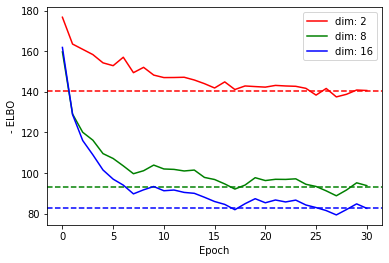

In [15]:
for dim, c in zip(lst_latent_dims, ['r','g', 'b']):
  curve = dic_loss[dim]
  plt.plot(curve, color=c, label='dim: {}'.format(dim))
  loss = calc_loss(dic_vae[dim], tf.cast(x_test, tf.float32))
  plt.axhline(loss.numpy(), color=c, ls='--')
plt.xlabel('Epoch')
plt.ylabel('- ELBO')
plt.legend()

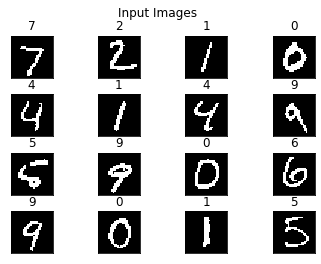

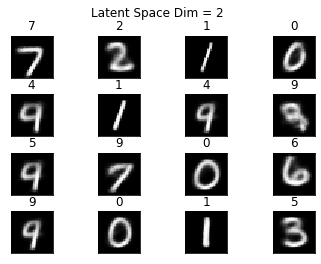

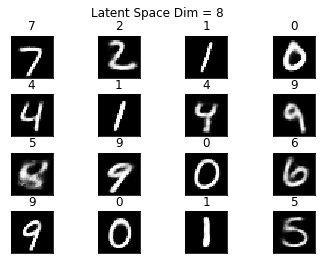

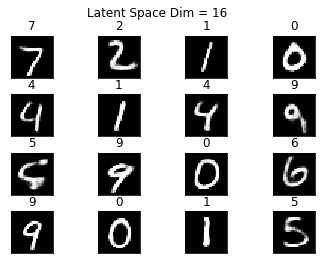

In [16]:
fig = plt.figure()
fig.suptitle('Input Images')
plot_images(x_test[0:], t_test[0:])

inputs = tf.cast(x_test, tf.float32)
for dim, vae in dic_vae.items():
  z_test = vae.encode_and_reparametrize(inputs)
  x_deco = vae.decode(z_test, to_prob=True).numpy()

  fig = plt.figure()
  fig.suptitle('Latent Space Dim = %i'%(dim))
  plot_images(x_deco[0:], t_test[0:])

## Case of 2-D Latent Space

In [0]:
vae = dic_vae[2]

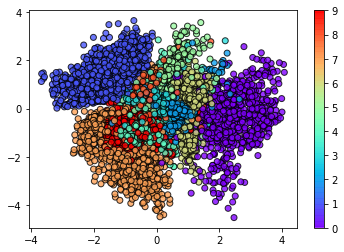

In [18]:
mu, logvar = vae.encode(tf.cast(x_test, tf.float32))
labels = t_test.argmax(axis=-1)
plt.scatter(mu[:,0], mu[:,1], c=labels, edgecolors='k', alpha=0.8, cmap='rainbow')
plt.colorbar()

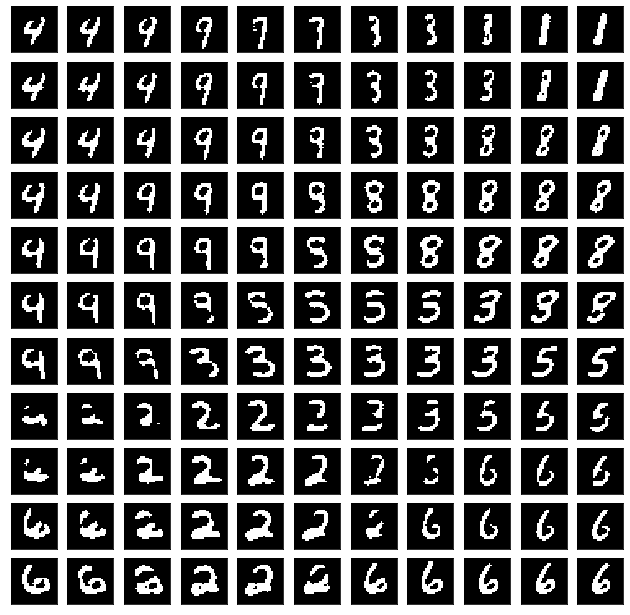

In [19]:
n = 11
fig,axes = plt.subplots(n,n,figsize=[11,11])

for i, x in enumerate(np.linspace(-1,1,n)):
  for j, y in enumerate(np.linspace(-1,1,n)):
    ax, z = axes[i,j], np.array([[x,y]])
    # z is a point in the 2-d latent space
    
    img = vae.decode(tf.Variable(z, dtype=tf.float32), to_prob=True)
    img = img.numpy().reshape(IMAGE_SIZE, IMAGE_SIZE)
    img[img >= .5] = 1.
    img[img < .5] = 0.
    
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# References

1. https://arxiv.org/abs/1312.6114
1. https://www.tensorflow.org/tutorials/generative/cvae
1. https://github.com/abdulfatir/normalizing-flows